In [15]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.tri as tri
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
%matplotlib inline

# 0. Functions

In [6]:
def like_calc(y_sim, y_mes, std):
    like = np.prod(stats.norm.pdf(y_sim, loc=y_mes, scale=std))
    return like

def ll_calc(y_sim, y_mes, std):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes, scale=std))
    return ll

def unc_calc(y_sim, y_mes, sim_unc_sq, mes_unc_sq):
    unc = ((y_sim - y_mes) / sim_unc_sq)**2 * (sim_unc_sq + mes_unc_sq)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [7]:
def getstats_unc(trainXY, ll1, ll2, ll3, ll4):
    med1 = trainXY[ll1].median()
    med2 = trainXY[ll2].median()
    med3 = trainXY[ll3].median()
    med4 = trainXY[ll4].median()
    stat1 = stats.describe(trainXY[ll1])
    stat2 = stats.describe(trainXY[ll2])
    stat3 = stats.describe(trainXY[ll3])
    stat4 = stats.describe(trainXY[ll4])
    print(f'5% Median: {med1} \n Stats: {stat1} \n')
    print(f'10% Median: {med2} \n Stats: {stat2} \n')
    print(f'15% Median: {med3} \n Stats: {stat3} \n')
    print(f'20% Median: {med4} \n Stats: {stat4} \n')
    meds = [med1, med2, med3, med4]
    maxs = [stat1.minmax[1], stat2.minmax[1], stat3.minmax[1], stat4.minmax[1]]
    means = [stat1.mean, stat2.mean, stat3.mean, stat4.mean]
    return meds, maxs, means

def getstats_rxtr(trainXY_pwr, trainXY_agr, trainXY_phwr, trainXY, ll):
    medpwr = trainXY_pwr[ll].median()
    medagr = trainXY_agr[ll].median()
    medphwr = trainXY_phwr[ll].median()
    medall = trainXY[ll].median()
    statpwr = stats.describe(trainXY_pwr[ll])
    statagr = stats.describe(trainXY_agr[ll])
    statphwr = stats.describe(trainXY_phwr[ll])
    statall = stats.describe(trainXY[ll])
    print(f'PWR Median: {medpwr} \n Stats: {statpwr} \n')
    print(f'BWR Median: {medagr} \n Stats: {statagr} \n')
    print(f'PHWR Median: {medphwr} \n Stats: {statphwr} \n')
    print(f'All Median: {medall} \n Stats: {statall} \n')
    meds = [medpwr, medagr, medphwr, medall]
    maxs = [statpwr.minmax[1], statagr.minmax[1], statphwr.minmax[1], statall.minmax[1]]
    means = [statpwr.mean, statagr.mean, statphwr.mean, statall.mean]
    return meds, maxs, means

In [9]:
def plotme(plots, pltlabels, zname, vmin, vmax):
    fig = plt.figure(figsize=(17, 14))
    cmap = sns.cubehelix_palette(6, as_cmap=True)
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    surfs = []
    for i, plotXY in enumerate(plots):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        x = plotXY['Burnup']
        y = plotXY['CoolingTime']
        triang = tri.Triangulation(x, y)
        z = plotXY[zname[i]]
        surf = ax.plot_trisurf(triang, z, linewidth=0.1, norm=norm, cmap=matplotlib.cm.viridis, shade=True)
        surfs.append(surf)
        ax.set_title(pltlabels[i], fontsize=18)
        ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=14, labelpad=15)
        ax.set_ylabel('Cooling Time [days]', fontsize=14, labelpad=15)
        ax.set_zlabel('Likelihood', fontsize=14, labelpad=15)
        #ax.set_xlim(0, 9000)
        ax.set_zlim(vmin, vmax)
    cbar_ax = fig.add_axes([0.00, 0.15, 0.02, 0.7])
    fig.colorbar(surfs[2], cax=cbar_ax)
    plt.tight_layout()
    plt.show()

# 1. Data formatting & LL calculations

In [53]:
pklfile = '../../prep-pkls/nucmoles_opusupdate_aug2019/not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']

## (a) Get test sample for LL calcs

In [23]:
XY.sample(10)

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,cs137,eu153,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152
8285,47268.91,28.044110,3.05,bw15x15,pwr,0.243300,13.2100,11.2600,1.698000,3.4840,12.5700,1.16400,0.251500,18.720,5.2920,7.3790,5.694000,0.02299,2.92600,0.85760
1451,2165.49,1.010173,1.85,ce16x16,pwr,0.000814,0.6534,0.5695,0.004052,0.1465,0.6044,0.01847,0.000666,4.015,0.2156,0.0222,0.000439,0.01102,0.09526,0.04532
13283,15642.73,1.001708,2.09,ge9x9-2,bwr,0.028410,4.6020,4.4230,0.195900,1.2400,4.2940,0.26080,0.032430,12.690,3.6070,2.0450,0.425900,0.01111,0.86090,0.43230
21973,65723.64,4612.466344,1.40,svea100-0,bwr,0.484200,18.1300,13.7700,0.033480,4.8570,12.5500,1.42000,0.092600,13.400,6.3740,2.5450,8.430000,0.01429,3.35600,1.10700
15081,38884.99,0.859527,3.27,ge10x10-8,bwr,0.188500,10.9400,9.6240,1.146000,3.6030,10.3000,0.96350,0.188700,18.360,5.0300,6.4350,4.296000,0.01454,2.32100,0.78800
5725,34290.31,279.206210,1.57,s14x14,pwr,0.112400,9.8110,8.9410,0.721700,1.9660,9.1210,0.79040,0.126500,14.270,5.4000,4.7260,3.274000,0.01851,2.05000,0.79530
13059,17233.87,37.125682,1.64,ge9x9-2,bwr,0.033770,5.0700,4.9140,0.219400,1.3230,4.7130,0.29580,0.036970,12.440,3.8740,2.1840,0.536900,0.01379,0.95400,0.47690
1237,48478.15,2502.593688,0.54,ce16x16,pwr,0.217100,13.6400,11.5700,0.168200,2.6020,11.0500,1.12700,0.109100,12.400,6.2770,3.2150,6.177000,0.01688,2.76400,1.01300
12439,54254.01,0.000000,4.09,ge8x8-1,bwr,0.353800,15.0500,12.2100,1.891000,4.7410,14.0500,1.30100,0.267400,16.920,5.1050,6.4110,6.566000,0.01118,3.15700,0.92570
18504,45938.58,0.000725,5.08,atrium9x9-9,bwr,0.258100,12.8300,10.9200,1.486000,4.1880,12.0400,1.13400,0.236000,18.480,5.1780,6.9700,5.348000,0.01252,2.75100,0.85410


In [54]:
# Choosing PWR sample intentionally
sim_idx = 10522
test_sample = XY.loc[XY.index == sim_idx].drop(lbls, axis=1)
test_answer = XY.loc[XY.index == sim_idx, lbls]
test_answer
#test_sample

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
10522,bwr,2421.282899,2.89,2024.53,ge7x7-0


In [55]:
XY.drop(10522, inplace=True)

## (b) LL calcs for uncertainty = 5%, 10%, 15%, 20%

In [56]:
fullXY = XY.loc[XY['Burnup'] > 0].copy()
X = fullXY.drop(lbls, axis=1)

In [57]:
uncs = [0.05, 0.10, 0.15, 0.20] 
for unc in uncs:
    like_name = 'Likelihood' + str(unc)
    fullXY[like_name] = X.apply(lambda row: like_calc(row, test_sample.iloc[0], unc*row), axis=1)
    ll_name = 'LogLikelihood_' + str(unc)
    fullXY[ll_name] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], unc*row), axis=1)
    unc_name = 'LLUncertainty_' + str(unc)
    fullXY[unc_name] = X.apply(lambda row: unc_calc(row, test_sample.iloc[0], (unc*row)**2, (unc*test_sample)**2), axis=1)

In [58]:
fullXY.to_csv('likelihood_idx10522_15nucs_opusupdate-aug2019.csv')
fullXY.head()

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,...,LLUncertainty_0.05,Likelihood0.1,LogLikelihood_0.1,LLUncertainty_0.1,Likelihood0.15,LogLikelihood_0.15,LLUncertainty_0.15,Likelihood0.2,LogLikelihood_0.2,LLUncertainty_0.2
1,2006.54,0.000839,0.53,ce14x14,pwr,0.000593,0.6109,0.5142,0.002411,0.1187,...,144.401032,1.295935e-131,-301.379415,72.200516,2.554691e-43,-98.073228,48.133677,2.295624e-13,-29.102601,36.100258
2,2006.54,0.592485,0.53,ce14x14,pwr,0.000600,0.6114,0.5204,0.002411,0.1209,...,142.963806,2.833535e-126,-289.084197,71.481903,5.462914e-41,-92.708007,47.654602,4.341161e-12,-26.162879,35.740951
3,2006.54,1.109213,0.53,ce14x14,pwr,0.000607,0.6114,0.5256,0.002410,0.1224,...,142.242179,2.075084e-123,-282.487965,71.121089,9.566980e-40,-89.845086,47.414060,2.058172e-11,-24.606618,35.560545
4,2006.54,8.460400,0.53,ce14x14,pwr,0.000681,0.6114,0.5759,0.002394,0.1238,...,139.681858,5.128500e-114,-260.859887,69.840929,1.022475e-35,-80.568252,46.560619,2.916976e-09,-19.652718,34.920465
5,2006.54,38.415629,0.53,ce14x14,pwr,0.000806,0.6114,0.6069,0.002329,0.1238,...,138.599281,2.220295e-109,-250.184135,69.299641,1.041416e-33,-75.944726,46.199760,3.572295e-08,-17.147473,34.649820


# 2. Likelihood for 4 simulated uncertainty values
This is std/scale in logpdf function

In [59]:
l1 = 'Likelihood0.05'
l2 = 'Likelihood0.1'
l3 = 'Likelihood0.15'
l4 = 'Likelihood0.2'
zname = [l1, l2, l3, l4]
uncss = ['5% Uncertainty', '10% Uncertainty', '15% Uncertainty', '20% Uncertainty']

In [60]:
meds, maxs, means = getstats_unc(fullXY, l1, l2, l3, l4)

5% Median: 0.0 
 Stats: DescribeResult(nobs=24677, minmax=(0.0, 6.356330555310312e+29), mean=3.1583054534712713e+25, variance=1.705341196462527e+55, skewness=149.00855941039225, kurtosis=22779.551022104268) 

10% Median: 1.1576601242222938e-263 
 Stats: DescribeResult(nobs=24677, minmax=(0.0, 1.163553171105317e+30), mean=1.6636021247920133e+26, variance=1.2066223110037162e+56, skewness=88.97463593194504, kurtosis=8668.954468949478) 

15% Median: 2.343793605938252e-115 
 Stats: DescribeResult(nobs=24677, minmax=(0.0, 2.424812915744353e+28), mean=6.916858349608066e+24, variance=9.635136581804264e+52, skewness=55.561454692955316, kurtosis=3390.857502142642) 

20% Median: 1.9898988001690178e-64 
 Stats: DescribeResult(nobs=24677, minmax=(0.0, 7.81528742143678e+26), mean=3.336454655034689e+23, variance=1.5332566302304816e+50, skewness=46.18661095779061, kurtosis=2315.9798658629798) 



In [61]:
plotXY = fullXY

/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'linewidth'


<Figure size 432x288 with 0 Axes>

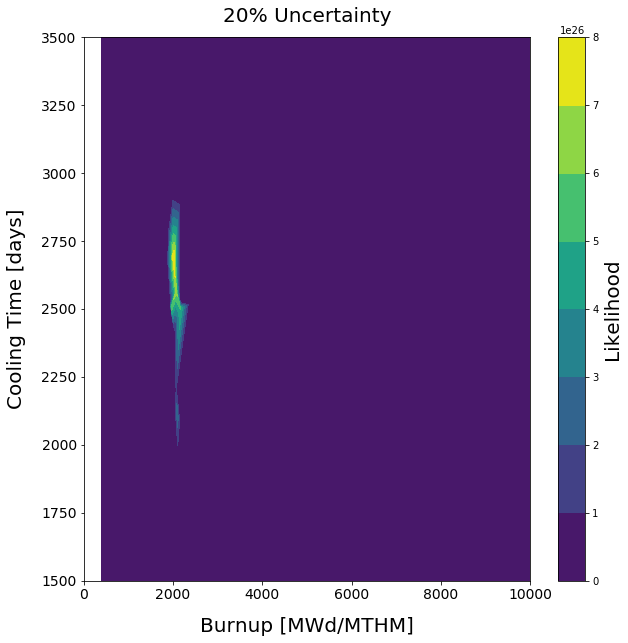

In [67]:
plt.clf()

vmin=0#meds[3]
vmax=maxs[3]

fig = plt.figure(figsize=(10, 10))
cmap = sns.cubehelix_palette(6, as_cmap=True)
norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
ax = fig.add_subplot(111)#, projection='3d')
x = plotXY['Burnup']
y = plotXY['CoolingTime']
triang = tri.Triangulation(x, y)

z = plotXY[l4]
ax.set_title(uncss[3], fontsize=20, pad=15)

surf = ax.tricontourf(triang, z, edgecolor='none', linewidth=0, antialiased=False, norm=norm, cmap=matplotlib.cm.viridis)#, shade=True)


ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=20, labelpad=15)
ax.set_ylabel('Cooling Time [days]', fontsize=20, labelpad=15)
ax.set_xlim(0, 10000)
ax.set_ylim(1500, 3500)

cbar = fig.colorbar(surf)
cbar.ax.set_ylabel('Likelihood', size=20)
ax.tick_params(labelsize=14)
plt.show()

fig.savefig('../results/19jan2020_15nuc/graphs/lsurf_idx10522_0.20unc.png', bbox_inches='tight', transparent=True)

# 3. Get LL Pred Results

In [68]:
ll1 = 'LogLikelihood_0.05'
ll2 = 'LogLikelihood_0.1'
ll3 = 'LogLikelihood_0.15'
ll4 = 'LogLikelihood_0.2'
lu1 = 'LLUncertainty_0.05'
lu2 = 'LLUncertainty_0.1'
lu3 = 'LLUncertainty_0.15'
lu4 = 'LLUncertainty_0.2'
lls = [ll1, ll2, ll3, ll4]
lus = [lu1, lu2, lu3, lu4]
uncs = ['5% Uncertainty', '10% Uncertainty', '15% Uncertainty', '20% Uncertainty']

In [69]:
fullXY.head()

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,...,LLUncertainty_0.05,Likelihood0.1,LogLikelihood_0.1,LLUncertainty_0.1,Likelihood0.15,LogLikelihood_0.15,LLUncertainty_0.15,Likelihood0.2,LogLikelihood_0.2,LLUncertainty_0.2
1,2006.54,0.000839,0.53,ce14x14,pwr,0.000593,0.6109,0.5142,0.002411,0.1187,...,144.401032,1.295935e-131,-301.379415,72.200516,2.554691e-43,-98.073228,48.133677,2.295624e-13,-29.102601,36.100258
2,2006.54,0.592485,0.53,ce14x14,pwr,0.000600,0.6114,0.5204,0.002411,0.1209,...,142.963806,2.833535e-126,-289.084197,71.481903,5.462914e-41,-92.708007,47.654602,4.341161e-12,-26.162879,35.740951
3,2006.54,1.109213,0.53,ce14x14,pwr,0.000607,0.6114,0.5256,0.002410,0.1224,...,142.242179,2.075084e-123,-282.487965,71.121089,9.566980e-40,-89.845086,47.414060,2.058172e-11,-24.606618,35.560545
4,2006.54,8.460400,0.53,ce14x14,pwr,0.000681,0.6114,0.5759,0.002394,0.1238,...,139.681858,5.128500e-114,-260.859887,69.840929,1.022475e-35,-80.568252,46.560619,2.916976e-09,-19.652718,34.920465
5,2006.54,38.415629,0.53,ce14x14,pwr,0.000806,0.6114,0.6069,0.002329,0.1238,...,138.599281,2.220295e-109,-250.184135,69.299641,1.041416e-33,-75.944726,46.199760,3.572295e-08,-17.147473,34.649820


## Reactor Prediction

In [70]:
data = {}
idx = {}
for ll, lu in zip(lls, lus):
    max_pwr = fullXY[ll].loc[fullXY['ReactorType'] == 'pwr'].max()
    idx_pwr = fullXY[ll].loc[fullXY['ReactorType'] == 'pwr'].idxmax()
    unc_pwr = float(fullXY[lu].loc[fullXY.index == idx_pwr])
    max_bwr = fullXY[ll].loc[fullXY['ReactorType'] == 'bwr'].max()
    idx_bwr = fullXY[ll].loc[fullXY['ReactorType'] == 'bwr'].idxmax()
    unc_bwr = float(fullXY[lu].loc[fullXY.index == idx_bwr])
    max_phwr = fullXY[ll].loc[fullXY['ReactorType'] == 'phwr'].max()
    idx_phwr = fullXY[ll].loc[fullXY['ReactorType'] == 'phwr'].idxmax()
    unc_phwr = float(fullXY[lu].loc[fullXY.index == idx_phwr])
    data[ll] = [max_pwr, max_bwr, max_phwr]
    data[lu] = [unc_pwr, unc_bwr, unc_phwr]
    idx[ll] = [idx_pwr, idx_bwr, idx_phwr]
rxtr = pd.DataFrame(data, columns=[ll1, lu1, ll2, lu2, ll3, lu3, ll4, lu4], index=['pwr', 'bwr', 'phwr'])
rxtr

,LogLikelihood_0.05,LLUncertainty_0.05,LogLikelihood_0.1,LLUncertainty_0.1,LogLikelihood_0.15,LLUncertainty_0.15,LogLikelihood_0.2,LLUncertainty_0.2
pwr,64.122342,8.983771,68.220774,4.576570,64.857494,3.051047,61.733670,2.649219
bwr,68.624419,7.251779,69.229031,3.625890,65.358137,2.634864,61.923294,2.914422
phwr,-287.786633,35.904032,-22.409230,17.952016,22.578165,11.968011,36.137215,8.976008


In [71]:
idx

{'LogLikelihood_0.05': [7971, 21014, 24359],
 'LogLikelihood_0.1': [1274, 21014, 24359],
 'LogLikelihood_0.15': [1274, 19062, 24359],
 'LogLikelihood_0.2': [7790, 13450, 24359]}

In [72]:
for ll in lls:
    print(ll)
    for i, index in enumerate(idx[ll]):
        print(fullXY.loc[fullXY.index == idx[ll][i], ['ReactorType', 'Burnup']])

LogLikelihood_0.05
     ReactorType   Burnup
7971         pwr  2071.39
      ReactorType   Burnup
21014         bwr  1963.55
      ReactorType   Burnup
24359        phwr  3308.69
LogLikelihood_0.1
     ReactorType   Burnup
1274         pwr  2165.49
      ReactorType   Burnup
21014         bwr  1963.55
      ReactorType   Burnup
24359        phwr  3308.69
LogLikelihood_0.15
     ReactorType   Burnup
1274         pwr  2165.49
      ReactorType   Burnup
19062         bwr  2030.98
      ReactorType   Burnup
24359        phwr  3308.69
LogLikelihood_0.2
     ReactorType   Burnup
7790         pwr  2071.39
      ReactorType   Burnup
13450         bwr  2010.26
      ReactorType   Burnup
24359        phwr  3308.69


In [73]:
for ll in lls:
    print(ll)
    for i, index in enumerate(idx[ll]):
        print(fullXY.loc[fullXY.index == idx[ll][i], ['ReactorType', 'CoolingTime']])

LogLikelihood_0.05
     ReactorType  CoolingTime
7971         pwr  2566.583998
      ReactorType  CoolingTime
21014         bwr  2503.299058
      ReactorType  CoolingTime
24359        phwr  2519.487975
LogLikelihood_0.1
     ReactorType  CoolingTime
1274         pwr  2502.593688
      ReactorType  CoolingTime
21014         bwr  2503.299058
      ReactorType  CoolingTime
24359        phwr  2519.487975
LogLikelihood_0.15
     ReactorType  CoolingTime
1274         pwr  2502.593688
      ReactorType  CoolingTime
19062         bwr  2122.469458
      ReactorType  CoolingTime
24359        phwr  2519.487975
LogLikelihood_0.2
     ReactorType  CoolingTime
7790         pwr  2566.583998
      ReactorType  CoolingTime
13450         bwr  2690.358732
      ReactorType  CoolingTime
24359        phwr  2519.487975


In [81]:
max_tot = fullXY[ll1].max()
idx = fullXY[ll1].idxmax()
max_tot, idx

(68.62441895096356, 21014)

In [78]:
sim_idx = 21014
top_answer = XY.loc[XY.index == sim_idx, lbls]
top_answer

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
21014,bwr,2503.299058,4.36,1963.55,svea64-1


In [79]:
sim_idx = 5010
top_answer = XY.loc[XY.index == sim_idx, lbls]
top_answer

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
5010,pwr,306.249839,3.22,39382.5,w17x17


In [82]:
xy = pd.read_csv('likelihood_idx5010_15nucs_opusupdate-aug2019.csv')

In [83]:
xy.head()

,Unnamed: 0,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,...,LLUncertainty_0.05,Likelihood0.1,LogLikelihood_0.1,LLUncertainty_0.1,Likelihood0.15,LogLikelihood_0.15,LLUncertainty_0.15,Likelihood0.2,LogLikelihood_0.2,LLUncertainty_0.2
0,1,2006.54,0.000839,0.53,ce14x14,pwr,0.000593,0.6109,0.5142,0.002411,...,2.507794e+10,0.0,-6.276547e+10,1.253897e+10,0.0,-2.789577e+10,8.359314e+09,0.0,-1.569137e+10,6.269485e+09
1,2,2006.54,0.592485,0.53,ce14x14,pwr,0.000600,0.6114,0.5204,0.002411,...,2.507794e+10,0.0,-6.276537e+10,1.253897e+10,0.0,-2.789572e+10,8.359314e+09,0.0,-1.569134e+10,6.269485e+09
2,3,2006.54,1.109213,0.53,ce14x14,pwr,0.000607,0.6114,0.5256,0.002410,...,2.507794e+10,0.0,-6.276530e+10,1.253897e+10,0.0,-2.789569e+10,8.359314e+09,0.0,-1.569132e+10,6.269485e+09
3,4,2006.54,8.460400,0.53,ce14x14,pwr,0.000681,0.6114,0.5759,0.002394,...,2.507794e+10,0.0,-6.276469e+10,1.253897e+10,0.0,-2.789542e+10,8.359314e+09,0.0,-1.569117e+10,6.269485e+09
4,5,2006.54,38.415629,0.53,ce14x14,pwr,0.000806,0.6114,0.6069,0.002329,...,2.507794e+10,0.0,-6.276476e+10,1.253897e+10,0.0,-2.789545e+10,8.359314e+09,0.0,-1.569119e+10,6.269486e+09


In [85]:
max_tot = xy[ll1].max()
idx = xy[ll1].idxmax()
max_tot, idx

(18.967564797385485, 2831)

In [86]:
sim_idx = 2831
top_answer = xy.loc[xy.index == sim_idx, lbls]
top_answer

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
2831,pwr,392.313045,3.07,40412.05,w14x14
